# SIT720 Assignment 3
Bryon Baker

Student number: 85031775

In [1]:
!pip3 install numpy==1.22.3
!pip3 install pandas==1.4.2
!pip3 install scikit-learn==1.0.2
!pip3 install graphviz==0.2.0

You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import warnings
import timeit
import random
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
# Configure ssl for unverified content so we can load a dataset from an unknown source (github).
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Question 1

Load and explore the training dataset. Explain the steps that you have taken.

In [3]:
import os

HOME = os.getenv('HOME')
print(HOME)

train_url = 'https://raw.githubusercontent.com/bryonbaker/datasets/main/SIT720/Ass3/ac_train_data.csv'
test_url = 'https://raw.githubusercontent.com/bryonbaker/datasets/main/SIT720/Ass3/ac_test_data.csv'

train_path = HOME+"/datasets/SIT720/Ass3/ac_train_data.csv"
test_path = HOME+"/datasets/SIT720/Ass3/ac_test_data.csv"

#
# Work out if the datasets are local. If not use a remote url. Preference is local.
#
print("Load datasets from local or remote resource:")
print("="*50)
if os.path.isfile(train_path):
    print(f"Training data is local: {train_path}")
    training_data = train_path
else:
    print("Training data is remote: {}".format(train_url))
    training_data = train_url

if os.path.isfile(test_path):
    print(f"Test data is local: {test_path}")
    test_data = test_path
else:
    print("Test data is remote: {}".format(test_url))
    test_data = test_url
print()

# Load the datasets from either local or remote.
eng_train_df = pd.read_csv(training_data)
eng_val_df = pd.read_csv(test_data)

/opt/app-root/src
Load datasets from local or remote resource:
Training data is remote: https://raw.githubusercontent.com/bryonbaker/datasets/main/SIT720/Ass3/ac_train_data.csv
Test data is remote: https://raw.githubusercontent.com/bryonbaker/datasets/main/SIT720/Ass3/ac_test_data.csv



### Pairplot
Generate a Pairplot to provide a rapid summary of the data distribution and inform any initial perspceive on correlation between features and the class

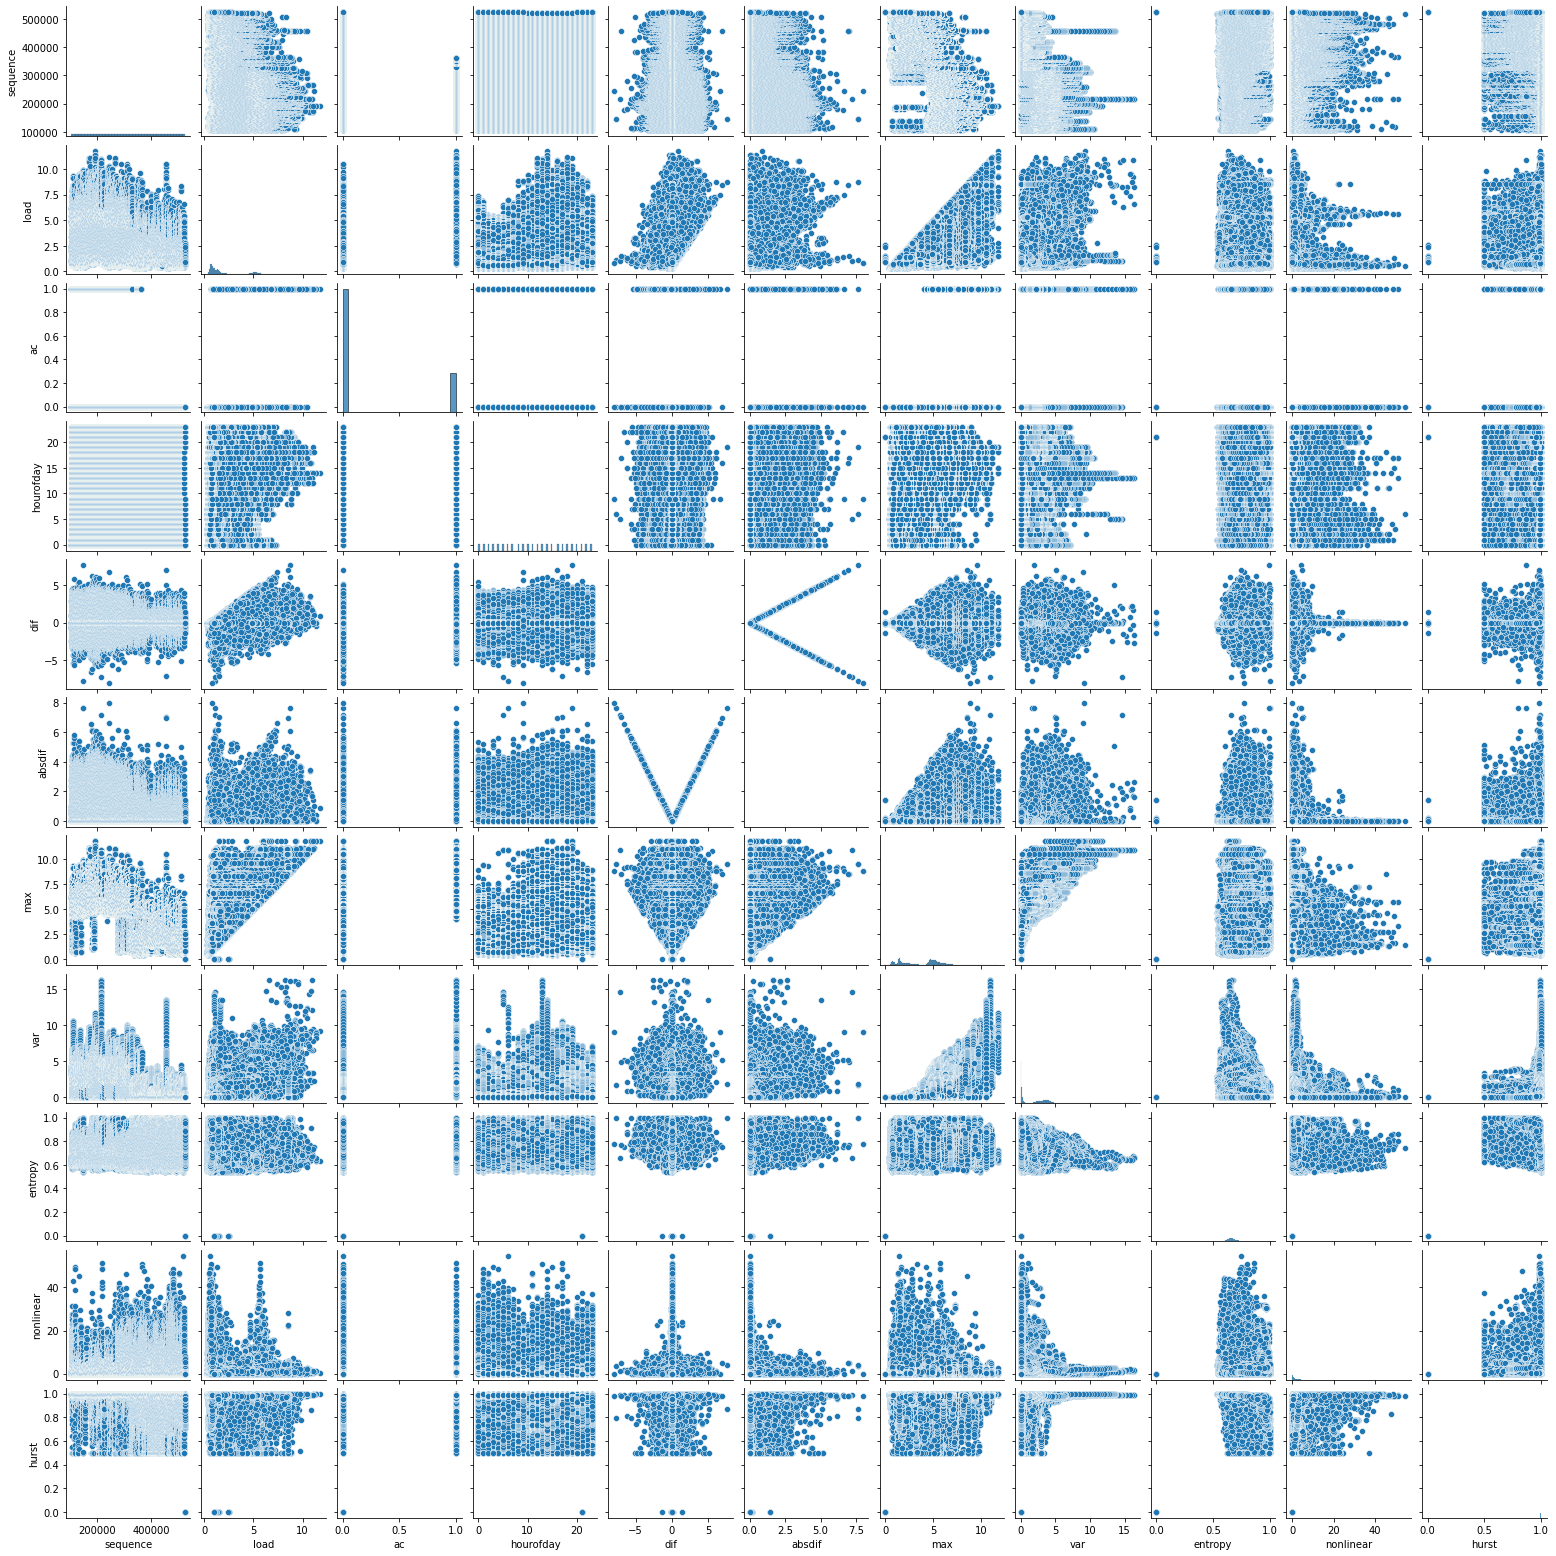

In [4]:
# Generate a pairplot
sn.pairplot(eng_train_df[eng_train_df.columns], height=2.0)

In [5]:
# Drop the columns not used in the assignment

# Drop the sequence number (column 0) from the test dataset. Column 0 is unlabeled so use the index number.
eng_train_df = eng_train_df.drop(eng_train_df.columns[[0]],axis=1)
eng_val_df = eng_val_df.drop(eng_val_df.columns[[0]],axis=1)

In [6]:
# Ordinal encode the days of week.

oldCol = "dayofweek"
newCol = "dayofweeknum"
dayMap = {'Sun' : 0, 'Mon': 1, "Tue" : 2, "Wed" : 3, "Thu" : 4, "Fri" : 5, "Sat" : 6 }    # How to map the values

eng_train_df[newCol] = eng_train_df[oldCol].map(dayMap)    # Adds a new column with proper boolean values
eng_train_df = eng_train_df.drop([oldCol], axis=1)    # Drop the old column before renaming the new column to the name just dropped
eng_train_df = eng_train_df.rename(columns={newCol : oldCol})
      
eng_train_df.head()

,load,ac,hourofday,dif,absdif,max,var,entropy,nonlinear,hurst,dayofweek
0,2.245,0,0,0.987,0.987,6.215,3.074549,0.678886,0.052903,0.994071,0
1,2.259,0,0,0.014,0.014,6.215,3.172867,0.667450,0.054829,0.994154,0
2,2.269,0,0,0.010,0.010,6.215,3.270112,0.647777,0.056991,0.994220,0
3,2.268,0,0,-0.001,0.001,6.215,3.303763,0.629227,0.057606,0.994150,0
4,2.270,0,0,0.002,0.002,6.215,3.302744,0.621295,0.082640,0.994041,0


In [7]:
# Ordinal encode the dayof week in the test dataset.
eng_val_df[newCol] = eng_val_df[oldCol].map(dayMap)    # Adds a new column with proper boolean values
eng_val_df = eng_val_df.drop([oldCol], axis=1)    # Drop the old column before renaming the new column to the name just dropped
eng_val_df = eng_val_df.rename(columns={newCol : oldCol})
      
eng_val_df.head()

,load,ac,hourofday,dif,absdif,max,var,entropy,nonlinear,hurst,dayofweek
0,1.869,0,0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,1
1,1.673,0,0,-0.196,0.196,0.0,0.0,0.0,0.0,0.0,1
2,1.660,0,0,-0.013,0.013,0.0,0.0,0.0,0.0,0.0,1
3,1.772,0,0,0.112,0.112,0.0,0.0,0.0,0.0,0.0,1
4,1.679,0,0,-0.093,0.093,0.0,0.0,0.0,0.0,0.0,1


In [8]:
# Split out the X and y from the datasets
eng_train_X = eng_train_df.drop(['ac'], axis=1)
eng_train_y = eng_train_df["ac"]
eng_val_X = eng_val_df.drop(['ac'], axis=1)
eng_val_y = eng_val_df['ac']

print("Training Dataset")
print(f"{eng_train_X.head()}\n")
print(f"{eng_train_y.head()}\n")

print("Testing Dataset")
print(f"{eng_val_X.head()}\n")
print(f"{eng_val_y.head()}\n")

Training Dataset
    load  hourofday    dif  absdif    max       var   entropy  nonlinear  \
0  2.245          0  0.987   0.987  6.215  3.074549  0.678886   0.052903   
1  2.259          0  0.014   0.014  6.215  3.172867  0.667450   0.054829   
2  2.269          0  0.010   0.010  6.215  3.270112  0.647777   0.056991   
3  2.268          0 -0.001   0.001  6.215  3.303763  0.629227   0.057606   
4  2.270          0  0.002   0.002  6.215  3.302744  0.621295   0.082640   

      hurst  dayofweek  
0  0.994071          0  
1  0.994154          0  
2  0.994220          0  
3  0.994150          0  
4  0.994041          0  

0    0
1    0
2    0
3    0
4    0
Name: ac, dtype: int64

Testing Dataset
    load  hourofday    dif  absdif  max  var  entropy  nonlinear  hurst  \
0  1.869          0  0.000   0.000  0.0  0.0      0.0        0.0    0.0   
1  1.673          0 -0.196   0.196  0.0  0.0      0.0        0.0    0.0   
2  1.660          0 -0.013   0.013  0.0  0.0      0.0        0.0    0.0   


In [9]:
print("Summary Analysis of Dataset")
print(eng_train_X.describe())
print()

print("Summary Analysis of the Class")
print(eng_train_y.value_counts())

Summary Analysis of Dataset
                load      hourofday           dif         absdif  \
count  417720.000000  417720.000000  4.177200e+05  417720.000000   
mean        2.184664      11.484487 -7.038207e-07       0.159578   
std         1.890565       6.920358  5.309284e-01       0.506379   
min         0.298000       0.000000 -7.970000e+00       0.000000   
25%         0.807000       5.000000 -1.100000e-02       0.002000   
50%         1.279000      11.000000 -1.000000e-03       0.010000   
75%         3.358000      17.000000  8.000000e-03       0.043000   
max        11.794000      23.000000  7.619000e+00       7.970000   

                 max            var        entropy      nonlinear  \
count  417720.000000  417720.000000  417720.000000  417720.000000   
mean        3.977086       1.871247       0.707766       1.468806   
std         2.131094       1.787633       0.094367       2.610744   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.

Variable Correlation Matrix


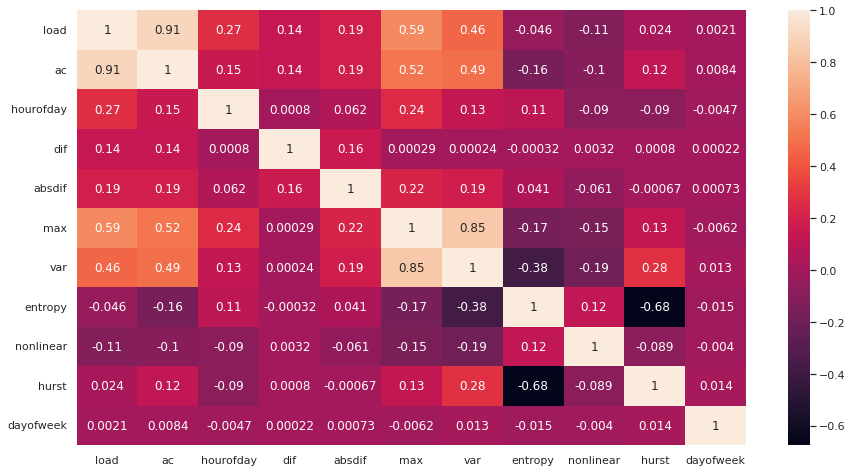

In [10]:
print("Variable Correlation Matrix")
corr_X = eng_train_df.corr()
sn.set(rc = {'figure.figsize':(15,8)})
sn.heatmap(corr_X, annot=True)
plt.show()

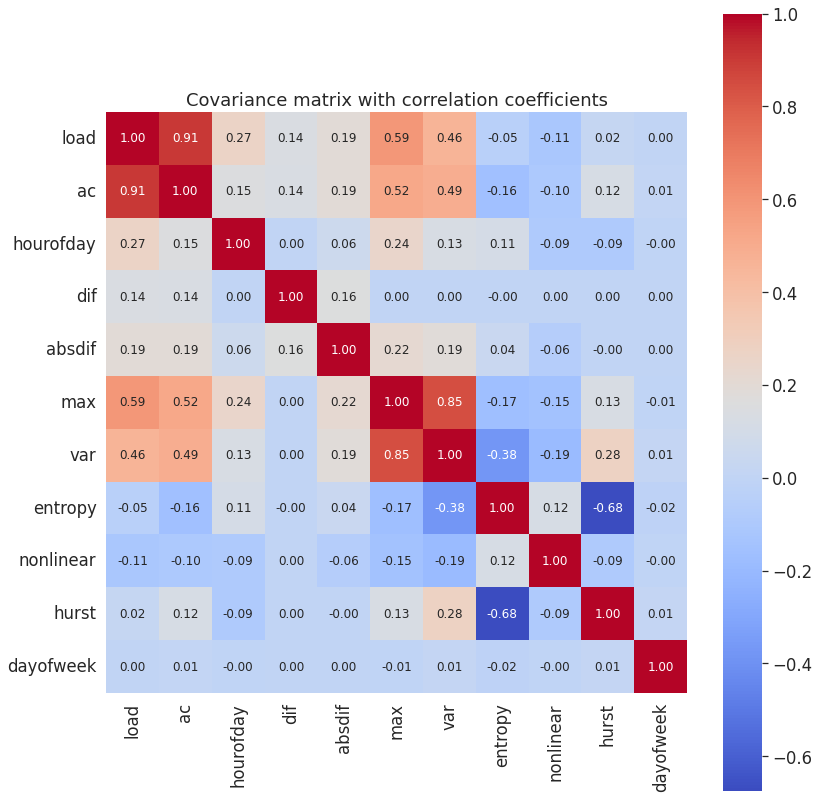

In [11]:
# Code snippet coutesy of: https://benjaminobi.medium.com/5-minutes-tutorial-on-how-to-compute-and-visualize-the-covariance-matrix-2597ab98d9ee#:~:text=The%20covariance%20matrix%20gives%20the,that%20displays%20the%20correlation%20coefficients.
#
stdsc = StandardScaler() 
X_std = stdsc.fit_transform(eng_train_df[eng_train_df.columns].iloc[:,range(0,len(eng_train_df.columns))].values)
cov_mat =np.cov(X_std.T)
plt.figure(figsize=(12,12))
sn.set(font_scale=1.5)
hm = sn.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12},
                 cmap='coolwarm',                 
                 yticklabels=eng_train_df.columns,
                 xticklabels=eng_train_df.columns)
plt.title('Covariance matrix with correlation coefficients', size = 18)
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

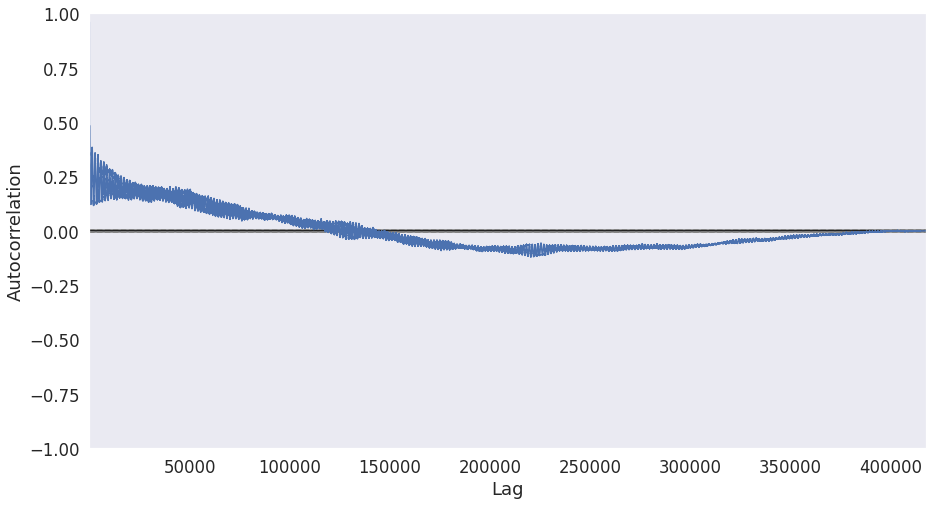

In [12]:
from pandas.plotting import autocorrelation_plot
# Plot an auto correlation to review the lag .
# A spike close to zero is evidence against autocorrelation
# A large spike is evidence of auto correlation
autocorrelation_plot(eng_train_df["load"])

There is a positive correlation within approximately the first 100,000 lags. 

The spikes at what appears to be < 1000 indicates that load is correlated for small windows of time. I.e. For a short period of time, when load is going up it continues to go up, and when load is going down it continues to go down.

Ref: https://www.dummies.com/article/technology/information-technology/data-science/big-data/autocorrelation-plots-graphical-technique-for-statistical-data-141241/


# Question 2
Analyse the importance of the feautues for predicting air conditioner status using two different approaches.

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif

def plotFeaturePerformance( fs, ticks, title ):
    # what are scores for the features
    for i in range(len(fs.scores_)):
        print('Feature %d: %f' % (i, fs.scores_[i]))
        
    # plot the scores
    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.xlabel("Feature")
    plt.ylabel("K-Best Score")
    plt.title(label=title, loc="center")
    plt.xticks(np.arange(len(ticks)), labels=ticks, rotation=70)
    
    plt.show()

def selectFeatures( X_train, y_pred, criteria, num_features ):
    fs = SelectKBest(criteria, k=num_features)
    fs.fit(X_train,y_pred)
    new_x_train = fs.transform(X_train)
    
    return new_x_train, fs

In [14]:
# Define the number of features to find.
num_features = 5
print("Column names:\n{}".format(eng_train_X.columns))
new_x_train1, fs1 = selectFeatures( eng_train_X, eng_train_y, f_classif, num_features )
new_x_train2, fs2 = selectFeatures( eng_train_X, eng_train_y, f_regression, num_features )

Column names:
Index(['load', 'hourofday', 'dif', 'absdif', 'max', 'var', 'entropy',
       'nonlinear', 'hurst', 'dayofweek'],
      dtype='object')


Feature 0: 1965360.570073
Feature 1: 9794.751825
Feature 2: 7858.763535
Feature 3: 15936.573793
Feature 4: 153445.765468
Feature 5: 134719.813549
Feature 6: 11663.758853
Feature 7: 4233.177434
Feature 8: 5883.074959
Feature 9: 29.446552


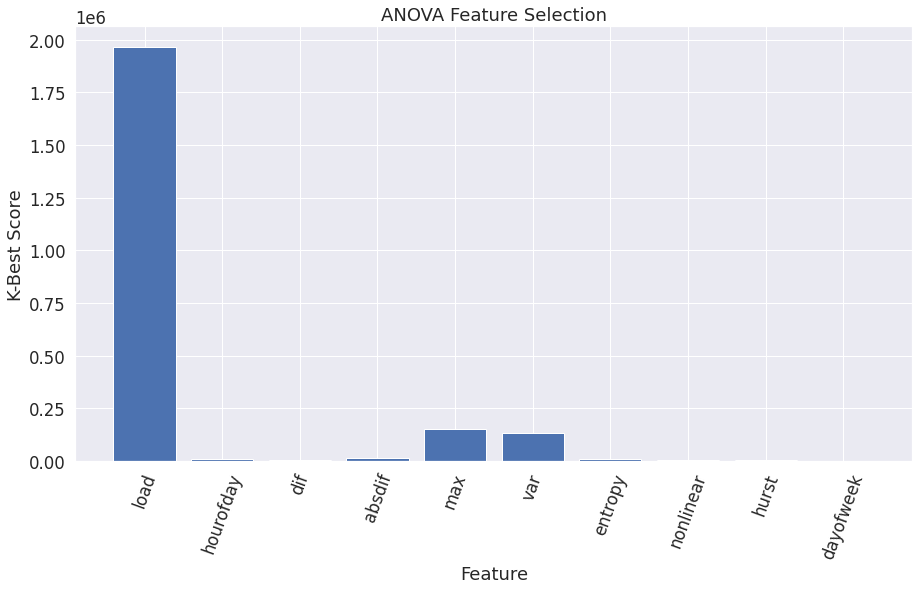

In [15]:
# Plot the feature selection charts.
plotFeaturePerformance( fs1, eng_train_X.columns, "ANOVA Feature Selection" )

Feature 0: 1965360.570075
Feature 1: 9794.751825
Feature 2: 7858.763535
Feature 3: 15936.573793
Feature 4: 153445.765468
Feature 5: 134719.813549
Feature 6: 11663.758853
Feature 7: 4233.177434
Feature 8: 5883.074959
Feature 9: 29.446552


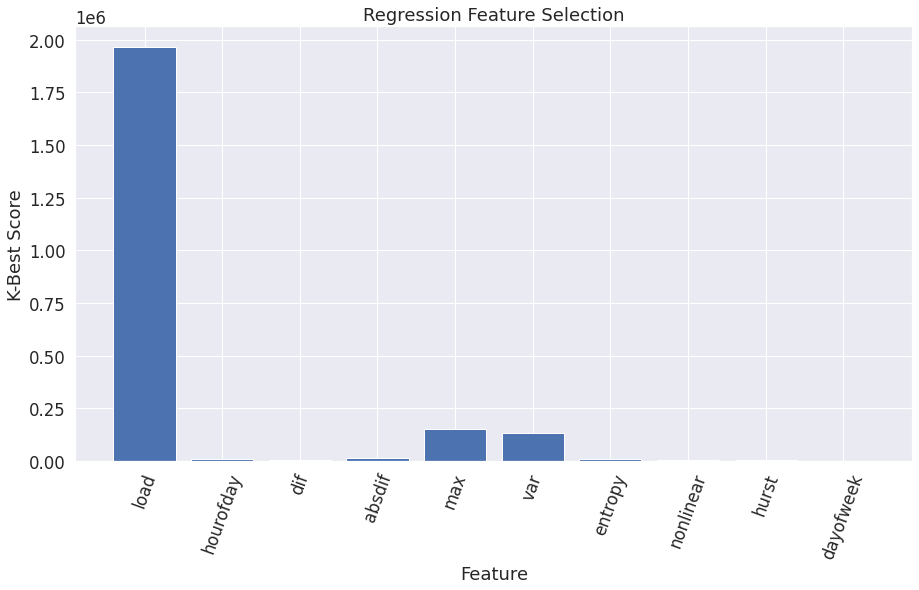

In [16]:
plotFeaturePerformance( fs2, eng_train_X.columns, "Regression Feature Selection" )

### PCA as a Test for Feature IMportance
Experiment using PCA as a way to evaluate feature significance

In [17]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
Xnorm = scale(eng_train_X)

# Perform the Principal Component Analysis. The number of components is the number of coumns in the dataset.
# The number of components is the minimum of the number of data elements and festures 
n_components=min(eng_train_X.shape[0], eng_train_X.shape[1])
print("Number of comoponets: {}".format(n_components))
n_components=7
pca = PCA(n_components)
Xnew = pca.fit_transform(Xnorm)
print("PCA details => {}".format(pca))

print(pca.get_params())

print('='*50)
print("Explained Variance:")
# Calculate the amount of variance explained by each PC
var= pca.explained_variance_ratio_
print(var)

print('='*50)
print("Cumulative Explained Variance:")

#cum_var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
cum_var=np.cumsum(pca.explained_variance_ratio_*100)
print(cum_var)

dimensions = {}

# Find the minimum dimensions that capture 85% and 95% respectively
num_dimensions = 0
for value in cum_var:
    if value >= 85:
        dimensions[value]=num_dimensions
        break
    num_dimensions += 1

num_dimensions = 0
for value in cum_var:
    if value >= 95:
        dimensions[value]=num_dimensions
        break
    num_dimensions += 1

print('='*50)

Number of comoponets: 10
PCA details => PCA(n_components=7)
{'copy': True, 'iterated_power': 'auto', 'n_components': 7, 'random_state': None, 'svd_solver': 'auto', 'tol': 0.0, 'whiten': False}
Explained Variance:
[0.26805069 0.16949796 0.11098643 0.09995123 0.09494228 0.08639147
 0.07730794]
Cumulative Explained Variance:
[26.80506905 43.75486477 54.85350804 64.8486306  74.3428584  82.98200525
 90.71279927]


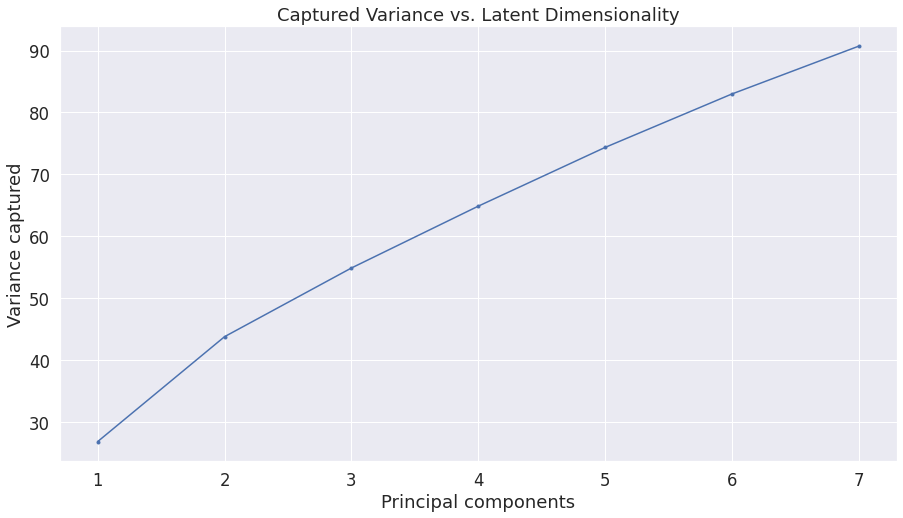

The minimum dimension that captures at least 91% variance is: 6


In [18]:
pca_num = a_list = list(range(1, n_components+1))
plt.plot(pca_num, cum_var, marker='.')
plt.xlabel("Principal components")
plt.ylabel("Variance captured")
plt.title(label="Captured Variance vs. Latent Dimensionality", loc="center")
plt.show()

for key,value in dimensions.items():
    print("The minimum dimension that captures at least {:.0f}% variance is: {}".format(key,value))

In [19]:
print(pca.components_)
print(type(pca.components_))
pca.components_.shape

[[ 0.4136197   0.16870047  0.05244207  0.18824096  0.53360172  0.54465109
  -0.28680188 -0.18683288  0.25234518  0.00765095]
 [ 0.30054484  0.35948565  0.11188161  0.22515584  0.178809   -0.01530307
   0.58629036  0.02577223 -0.58296344 -0.02786398]
 [ 0.03049698 -0.27599489  0.77850801  0.50965239 -0.12997361 -0.09420898
  -0.05767422  0.1302758   0.1007417   0.02934299]
 [-0.00333893 -0.02576101  0.01798983  0.00344505  0.01406988  0.00138708
  -0.01933977  0.03991924  0.02148007 -0.99817878]
 [ 0.11194558 -0.19726843 -0.12783213 -0.07621881  0.19428049  0.1537297
   0.00769343  0.92896711 -0.0155393   0.0417697 ]
 [-0.1632137  -0.58687994 -0.46666383  0.55076803  0.10698344  0.1440968
   0.14150839 -0.17393774 -0.15912065 -0.00223127]
 [-0.19594797  0.59023551 -0.29083845  0.5797916  -0.15706813 -0.16754008
  -0.12263242  0.22281009  0.27394982 -0.00308291]]
<class 'numpy.ndarray'>


(7, 10)

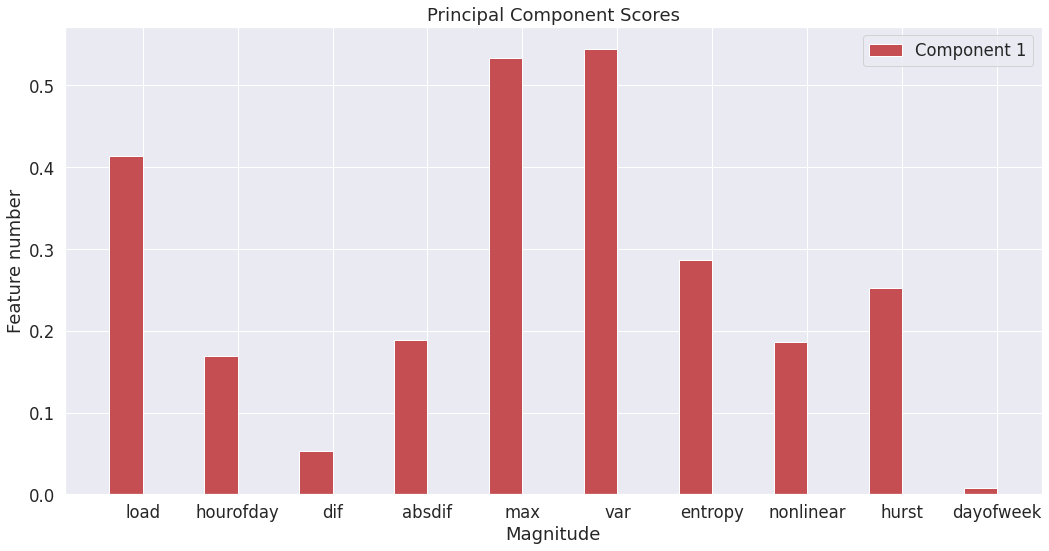

In [20]:
n_groups = pca.components_.shape[1]

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35

plt.bar(index, np.absolute(pca.components_[0,:]), 
        bar_width,
        color='r',
        label='Component 1')

plt.xlabel('Magnitude')
plt.ylabel('Feature number')
plt.title('Principal Component Scores')
#plt.xticks(index + bar_width / 2, ('A', 'B', 'C', 'D', 'E'))
plt.xticks(index+bar_width/2, eng_train_X.columns)
plt.legend()

plt.tight_layout()
plt.show()

## Feature Engineering
Now that we have analysed the features and their importance we will create a new training dataset that has the features we want in the final train/test dataset and a validation dataset.

In [21]:
train_X = eng_train_X
train_y = eng_train_y
val_X = eng_val_X
val_y = eng_val_y

In [22]:
# Drop the features that are no critical to the training
train_X = eng_train_X
train_X = train_X.drop(['dif','nonlinear','hurst','dayofweek'], axis=1)
val_X = eng_val_X
val_X = val_X.drop(['dif','nonlinear','hurst','dayofweek'], axis=1)
print(train_X.head)
print(val_X.head)

<bound method NDFrame.head of          load  hourofday  absdif    max       var   entropy
0       2.245          0   0.987  6.215  3.074549  0.678886
1       2.259          0   0.014  6.215  3.172867  0.667450
2       2.269          0   0.010  6.215  3.270112  0.647777
3       2.268          0   0.001  6.215  3.303763  0.629227
4       2.270          0   0.002  6.215  3.302744  0.621295
...       ...        ...     ...    ...       ...       ...
417715  2.543         21   0.003  0.000  0.000000  0.000000
417716  2.417         21   0.126  0.000  0.000000  0.000000
417717  0.999         21   1.418  0.000  0.000000  0.000000
417718  0.966         21   0.033  0.000  0.000000  0.000000
417719  0.964         21   0.002  0.000  0.000000  0.000000

[417720 rows x 6 columns]>
<bound method NDFrame.head of          load  hourofday  absdif    max       var   entropy
0       1.869          0   0.000  0.000  0.000000  0.000000
1       1.673          0   0.196  0.000  0.000000  0.000000
2       1.66

# Question 3
Based on the training data, create three different supervised machine learning models excet any ensemble approach for predicting air conditioner status
   1.	Report performance score using a suitable metric on the test data. Is it possible that the presented result is an underfitted or overfitted one? Justify.  
   2.	Justify different design decisions for each ML model used to answer this question.
   3.	Have you optimised any hyper-parameters for each ML model? What are they? Why have you done that? Explain. 
   4.	Finally, make a recommendation based on the reported results and justify it.

For the initial train/test we shall use the full feature set. But after we have selected the model we will drop the unrequired columns.

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

### Helper Functions
Define soe helper funcitons

In [24]:
import timeit

def current_milli_time():
    return round(time.time() * 1000)

In [25]:
from sklearn import metrics

def display_stats(y_test, y_pred):
    # Model Accuracy: how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:",metrics.precision_score(y_test, y_pred))

    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Recall:",metrics.recall_score(y_test, y_pred))

    #Calculate F1 Score
    print("F1 Score:",metrics.f1_score(y_test, y_pred))

    #Calculate Mean Absolute Error
    print("Mean Absolute Error:",metrics.mean_absolute_error(y_test, y_pred))

    # kappa
    print("Cohens kappa:", metrics.cohen_kappa_score(y_test, y_pred))

    # ROC AUC
    print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred))

In [26]:
def validate_model( model, validation_dataset_X, validation_dataset_y ):
    print(f"Validating model: {model}")
    start = timeit.default_timer()
    
    y_pred = model.predict( validation_dataset_X )
    
    stop = timeit.default_timer()
    predict_time = stop - start
    
    # Find the performance info
    accuracy = metrics.accuracy_score(validation_dataset_y, y_pred)
    precision = metrics.precision_score(validation_dataset_y, y_pred)
    recall = metrics.recall_score(validation_dataset_y, y_pred)
    f1 = metrics.f1_score(validation_dataset_y, y_pred)
    
    return accuracy, precision, recall, f1, predict_time

In [27]:
import warnings
# Some of the hyper parameter combinations are invalid. Supress the warnings.
warnings.filterwarnings('ignore')

### Test using the Decision Tree Model
The decision tree is a fast and explainable model. The most common hyperparameters to tune are the max leaf nodes, criterion and the minimum samples before you can split.

In [28]:
def perform_decision_tree( df_X, df_y, c, m, s ):
    skf = StratifiedKFold(n_splits=10)
    score = []
    start = timeit.default_timer()
    for train_index, test_index in skf.split(df_X, df_y):
        X_tr = df_X.iloc[train_index]
        X_val = df_X.iloc[test_index]
        y_tr = df_y.iloc[train_index]
        y_val = df_y.iloc[test_index]

        # Train the model with the training split
        model = DecisionTreeClassifier(criterion = c, max_leaf_nodes=m, min_samples_split=s)
        model.fit(X_tr, y_tr)

        # Now work with the testing split (vaidation set) and measure the performance
        y_pred = model.predict(X_val)

        # Find the performance info
        accuracy = metrics.accuracy_score(y_val, y_pred)
        precision = metrics.precision_score(y_val, y_pred)
        recall = metrics.recall_score(y_val, y_pred)
        f1 = metrics.f1_score(y_val, y_pred)

        # Store the results so we can average them after all the splits have been run.
        score.append([accuracy, precision, recall, f1])

    stop = timeit.default_timer()
    train_time = stop - start
    return model, score, train_time

In [29]:
max_leaf_nodes = [10, 50, 100, 500]
criterion = ["gini", "entropy"]
min_samples_split = [2,3,4,8]

score = []
avg_score= []
for c in criterion:
    for m in max_leaf_nodes:     
        for s in min_samples_split:   
            _, score, train_time = perform_decision_tree( train_X, train_y, c, m, s )

            # print(f"score: {score}")
            averages = np.array(score).mean(axis=0)
            
            print(f"{c} {m} {s}: Averages: {averages}, Train time: {train_time}")

gini 10 2: Averages: [0.98659868 0.96957191 0.97556284 0.97248405], Train time: 7.633497620932758
gini 10 3: Averages: [0.98659868 0.96957191 0.97556284 0.97248405], Train time: 7.525989316171035
gini 10 4: Averages: [0.98659868 0.96957191 0.97556284 0.97248405], Train time: 7.569652273086831
gini 10 8: Averages: [0.98659868 0.96957191 0.97556284 0.97248405], Train time: 7.540494060143828
gini 50 2: Averages: [0.98866226 0.97742708 0.97585942 0.97660292], Train time: 10.17747426405549
gini 50 3: Averages: [0.98866226 0.97742708 0.97585942 0.97660292], Train time: 10.614229916827753
gini 50 4: Averages: [0.98866226 0.97742708 0.97585942 0.97660292], Train time: 10.62078798795119
gini 50 8: Averages: [0.98866226 0.97742708 0.97585942 0.97660292], Train time: 10.434056665049866
gini 100 2: Averages: [0.98814756 0.97540443 0.97598787 0.97560778], Train time: 12.746814385987818
gini 100 3: Averages: [0.98814278 0.97540377 0.97596811 0.97559767], Train time: 12.763617862947285
gini 100 4: Av

Using the best model run a dedicated test

In [36]:
model, score, train_time = perform_decision_tree( train_X, train_y, 'gini', 10, 8 )
print(f"Trained results: {np.array(score).mean(axis=0)}. Train time: {train_time}")

print("Validating model with validation dataset:")
accuracy, precision, recall, f1, predict_time = validate_model( model, val_X, val_y )
print(f"Accuracy {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}, Predict time: {predict_time}")


Trained results: [0.98866226 0.97742708 0.97585942 0.97660292]. Train time: 10.352809234056622
Validating model with validation dataset:
Validating model: DecisionTreeClassifier(max_leaf_nodes=50)
Accuracy 0.9802539321584234, Precision: 0.9210802002095216, Recall: 0.8491254426440605, F1: 0.883640424343942, Predict time: 0.0050893439911305904


[Text(0.3718220338983051, 0.95, 'X[0] <= 4.124\ngini = 0.367\nsamples = 375948\nvalue = [284869, 91079]'),
 Text(0.1483050847457627, 0.85, 'X[2] <= 0.99\ngini = 0.037\nsamples = 287050\nvalue = [281671, 5379]'),
 Text(0.05084745762711865, 0.75, 'X[2] <= 0.514\ngini = 0.007\nsamples = 275819\nvalue = [274796, 1023]'),
 Text(0.03389830508474576, 0.65, 'gini = 0.003\nsamples = 265799\nvalue = [265424, 375]'),
 Text(0.06779661016949153, 0.65, 'X[0] <= 3.724\ngini = 0.121\nsamples = 10020\nvalue = [9372, 648]'),
 Text(0.03389830508474576, 0.55, 'X[0] <= 1.396\ngini = 0.097\nsamples = 9756\nvalue = [9258, 498]'),
 Text(0.01694915254237288, 0.45, 'gini = 0.02\nsamples = 4459\nvalue = [4413, 46]'),
 Text(0.05084745762711865, 0.45, 'X[4] <= 1.72\ngini = 0.156\nsamples = 5297\nvalue = [4845, 452]'),
 Text(0.03389830508474576, 0.35, 'gini = 0.002\nsamples = 2152\nvalue = [2150, 2]'),
 Text(0.06779661016949153, 0.35, 'gini = 0.245\nsamples = 3145\nvalue = [2695, 450]'),
 Text(0.1016949152542373, 0

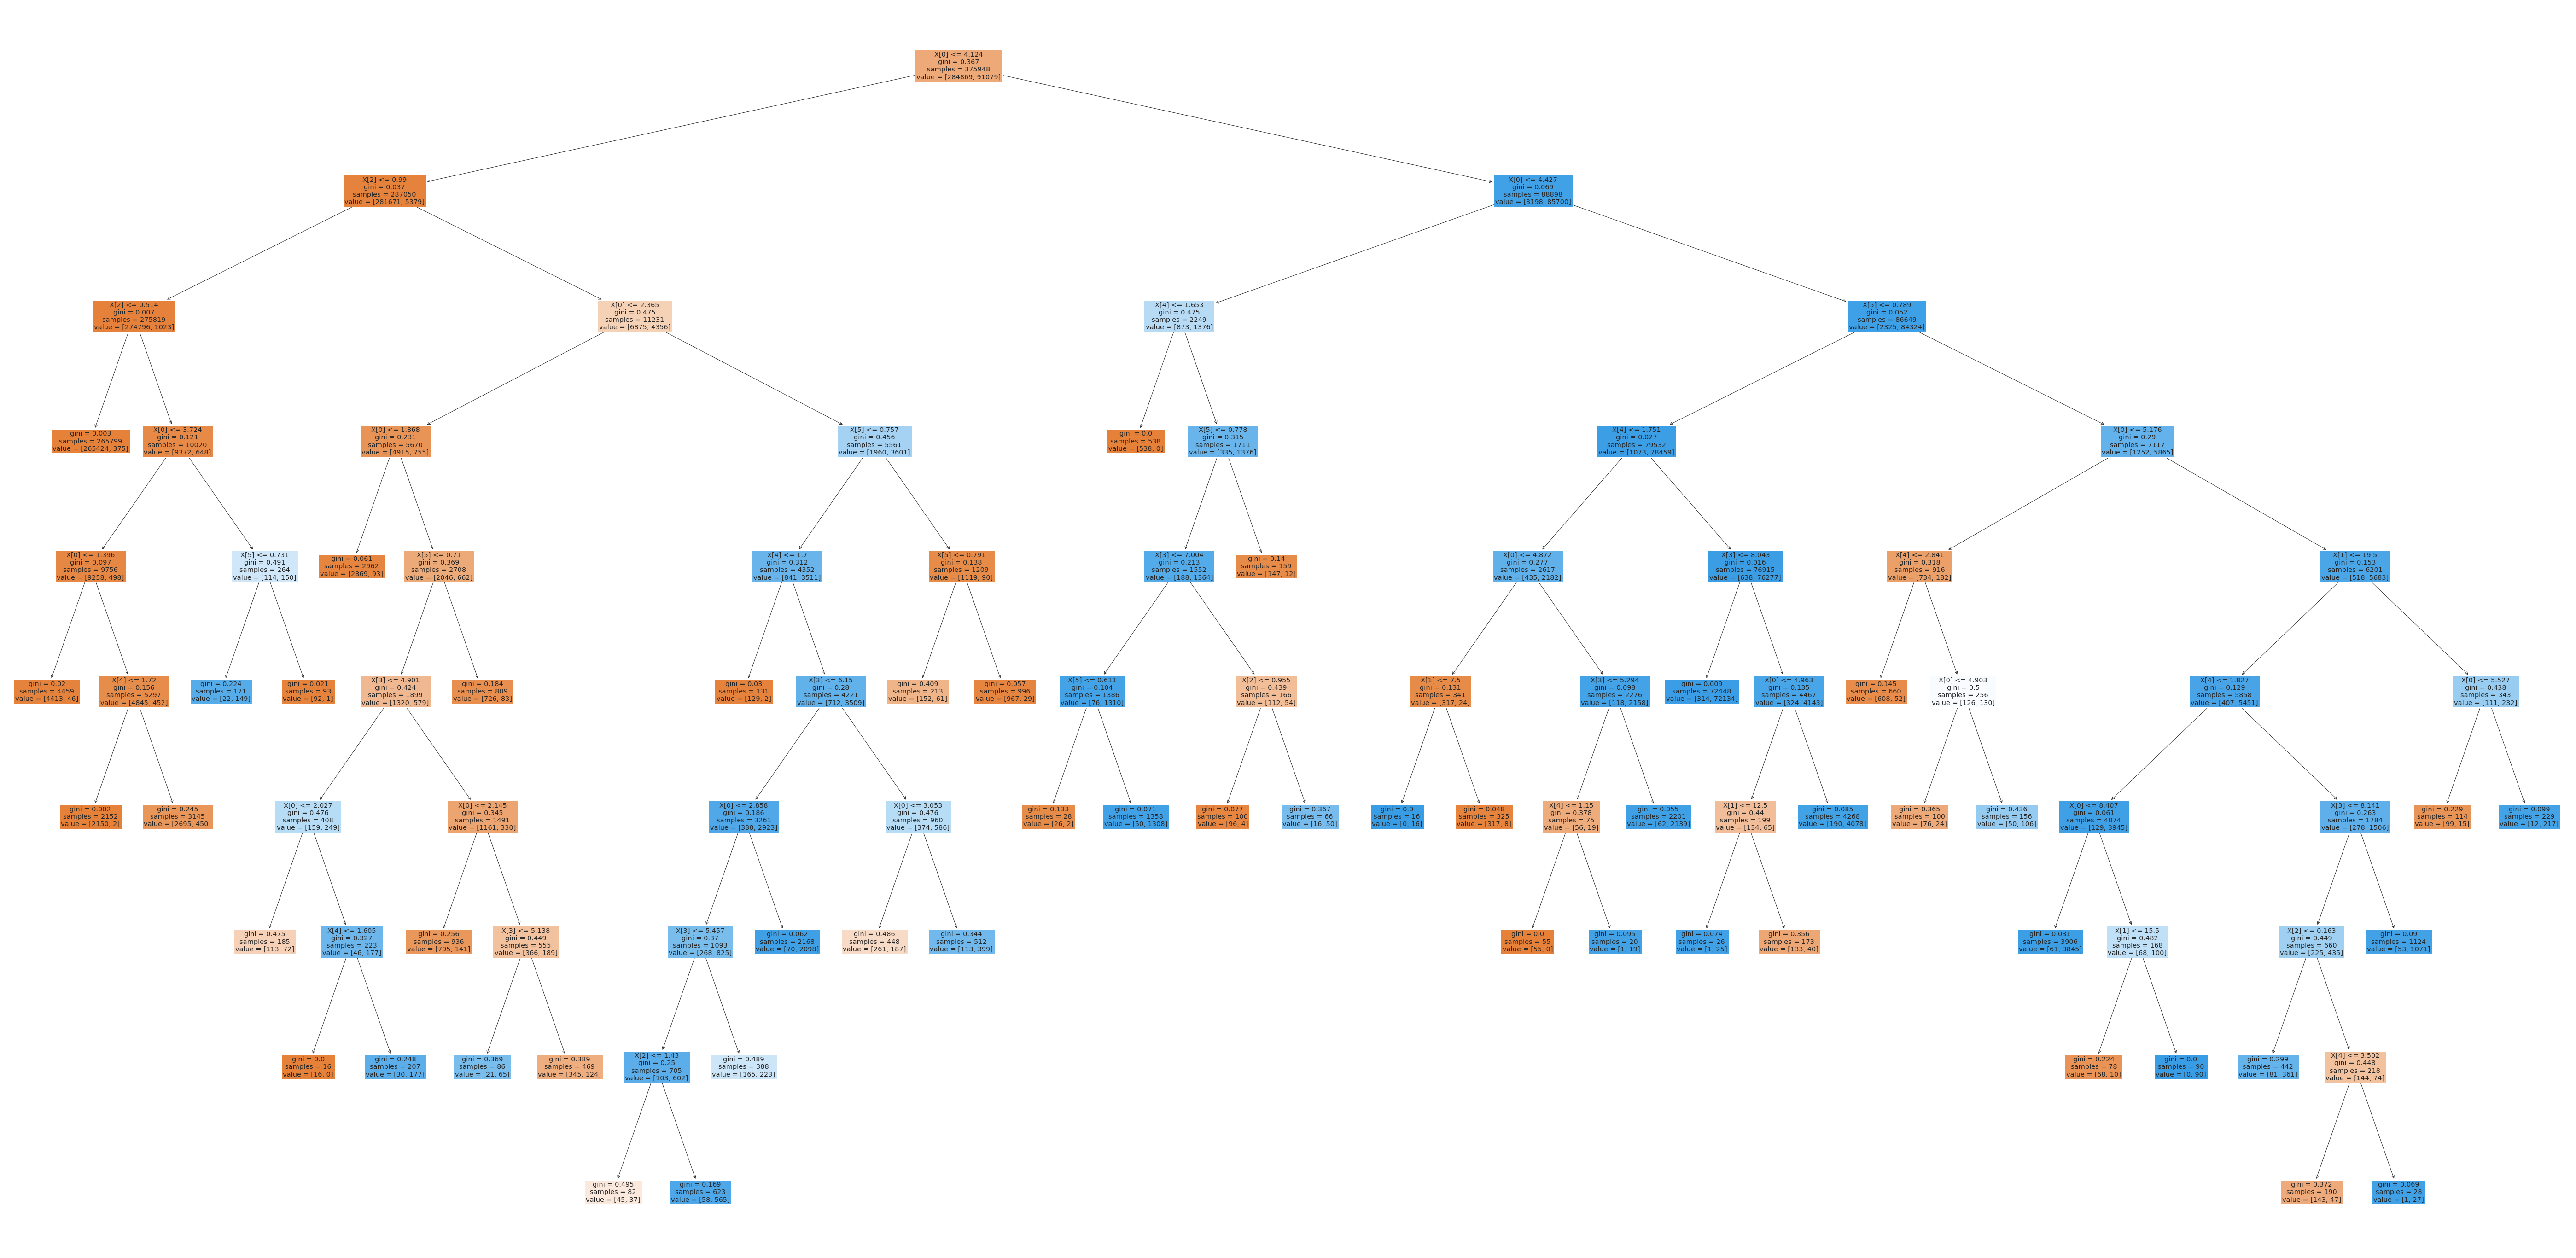

In [37]:
# Display the resulting decision tree
from sklearn import tree
plt.figure(figsize=(100,50))
tree.plot_tree(model,filled=True)

### Test Logistic Regression Model

In [31]:
def perform_logistic_regression(df_X, df_y, p, s, c):
    skf = StratifiedKFold(n_splits=10)
    score = []
    start = timeit.default_timer()
    for train_index, test_index in skf.split(df_X, df_y):
        X_tr = df_X.iloc[train_index]
        X_val = df_X.iloc[test_index]
        y_tr = df_y.iloc[train_index]
        y_val = df_y.iloc[test_index]

        # Train the model with the training split
        model = LogisticRegression(max_iter=10000, penalty=p, solver=s, C=int(c))
        model.fit(X_tr, y_tr)

        # Now work with the testing split (vaidation set) and measure the performance
        y_pred = model.predict(X_val)

        # Find the performance info
        accuracy = metrics.accuracy_score(y_val, y_pred)
        precision = metrics.precision_score(y_val, y_pred)
        recall = metrics.recall_score(y_val, y_pred)
        f1 = metrics.f1_score(y_val, y_pred)

        # Store the results so we can average them after all the splits have been run.
        score.append([accuracy, precision, recall, f1])

    stop = timeit.default_timer()
    train_time = stop - start

    return model, score, train_time

In [32]:
penalty = ['none','l2']     # have left out none because of feedback form previous runs and the fact it generates a ton of incompatable param warnings
solver = ['newton-cg', 'lbfgs', 'liblinear']
C = [100, 10, 1.0, 0.1, 0.01]

avg_score= []
for p in penalty:
    for s in solver:
        for c in C:
            if p == 'none' and s == 'liblinear':
                continue        # These are incompatible hyperparameters so skip them
            if p == 'l2' and c < 1.0:
                continue        # These are incompatible hyperparameters so skip them
             
            _, score, train_time = perform_logistic_regression( train_X, train_y, p, s, c )

            averages = np.array(score).mean(axis=0)
            
            print(f"Averages: penalty: {p} solver: {s} C: {c} {averages}. Train time: {train_time}")


Averages: penalty: none solver: newton-cg C: 100 [0.98389352 0.96426743 0.96965378 0.96689728]. Train time: 136.73837163997814
Averages: penalty: none solver: newton-cg C: 10 [0.98389352 0.96426743 0.96965378 0.96689728]. Train time: 143.02262348099612
Averages: penalty: none solver: newton-cg C: 1.0 [0.98389352 0.96426743 0.96965378 0.96689728]. Train time: 142.9850532959681
Averages: penalty: none solver: newton-cg C: 0.1 [0.98389352 0.96426743 0.96965378 0.96689728]. Train time: 137.58980152802542
Averages: penalty: none solver: newton-cg C: 0.01 [0.98389352 0.96426743 0.96965378 0.96689728]. Train time: 140.60333148390055
Averages: penalty: none solver: lbfgs C: 100 [0.98389112 0.96425828 0.96965378 0.96689261]. Train time: 91.2087848810479
Averages: penalty: none solver: lbfgs C: 10 [0.98389112 0.96425828 0.96965378 0.96689261]. Train time: 89.68432284705341
Averages: penalty: none solver: lbfgs C: 1.0 [0.98389112 0.96425828 0.96965378 0.96689261]. Train time: 90.4062827990856
Ave

Using the best model, run a dedicated test

In [33]:
model, score, train_time = perform_logistic_regression( train_X, train_y, 'l2', 'liblinear', 1.0 )
print(f"Trained results: {np.array(score).mean(axis=0)}. Train time: {train_time}")

print("Validating model with validation dataset:")
accuracy, precision, recall, f1, predict_time = validate_model( model, val_X, val_y )
print(f"Accuracy {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}, Predict time: {predict_time}")

Trained results: [0.98393421 0.96428357 0.96981188 0.96698337]. Train time: 10.697034201119095
Validating model with validation dataset:
Validating model: LogisticRegression(C=1, max_iter=10000, solver='liblinear')
Accuracy 0.9841766155012318, Precision: 0.886040173614616, Recall: 0.9419465607897843, F1: 0.9131384583376678, Predict time: 0.003706763032823801


### Test the SVM Model

In [34]:
def perform_svm(df_X, df_y, c):
    skf = StratifiedKFold(n_splits=10)
    score = []
    
    start = timeit.default_timer()
    for train_index, test_index in skf.split(df_X, df_y):
        X_tr = df_X.iloc[train_index]
        X_val = df_X.iloc[test_index]
        y_tr = df_y.iloc[train_index]
        y_val = df_y.iloc[test_index]

        # Train the model with the training split
        model = SVC(C=c)
        model.fit(X_tr, y_tr)

        # Now work with the testing split (vaidation set) and measure the performance
        y_pred = model.predict(X_val)

        # Find the performance info
        accuracy = metrics.accuracy_score(y_val, y_pred)
        precision = metrics.precision_score(y_val, y_pred)
        recall = metrics.recall_score(y_val, y_pred)
        f1 = metrics.f1_score(y_val, y_pred)

        # Store the results so we can average them after all the splits have been run.
        score.append([accuracy, precision, recall, f1])
        print(".", end="")
        #print(f"{[accuracy, precision, recall, f1]}")
    print()

    stop = timeit.default_timer()
    train_time = stop - start
    
    return model, score, train_time

Using the best model, run a dedicated test

In [35]:
model, score, train_time = perform_svm( train_X, train_y, 100 )
print(f"Trained results: {np.array(score).mean(axis=0)}. Train time: {train_time}")

print("Validating model with validation dataset:")
accuracy, precision, recall, f1, predict_time = validate_model( model, val_X, val_y )
print(f"Accuracy {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}, Predict time: {predict_time}")

..........
Trained results: [0.98824332 0.97599387 0.97561236 0.97575894]. Train time: 3507.1485379089136
Validating model with validation dataset:
Validating model: SVC(C=100)
Accuracy 0.9832385825279515, Precision: 0.9219763022579924, Recall: 0.8850735057409593, F1: 0.9031480974541473, Predict time: 54.83608422707766
